## Association between wildfire smoke and cardiopulmonary morbidity and mortality in Colorado

#### Ryan Gan
#### 2018-05-18

### Introduction

In this Jupyter notebook, I estimate the risk for cardiopulmonary mortality and morbidity due to an increase in PM<sub>2.5</sub>. I am using non-linear distributed lag models of a continous estimate of PM<sub>2.5</sub> and it's association on cardiopumonary outcomes. I will use Colorado mortality data and inpatient emergency room visits I received from Kirk Bol at CDPHE. I have residential location of county, zipcode, and a 3x3 grid size. This document only focuses on the association of PM<sub>2.5</sub>.

In [1]:
# loading r libraries
library(tidyverse)
library(dlnm)
library(survival)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::vars()   masks ggplot2::vars()
This is dlnm 2.3.4. For details: help(dlnm) and vignette('dlnmOverview').


### PM<sub>2.5</sub> data

Starting by setting up lag function. 

In [10]:
# defining a lag function
funlag <- function(var, n=6){
  var <- enquo(var)
  indices <- seq_len(n)
  map( indices, ~quo(lag(!!var, !!.x)) ) %>% 
    set_names(sprintf("%s_lag%d", rlang::quo_text(var), indices))
}

Reading in grid PM<sub>2.5</sub> and manipulating data.

In [65]:
# read grid pm; read grid id as character to avoid parsing error
grid_pm <- read_csv('../../data/smoke/1015-grid_pm.csv', 
                    col_types = cols(GRID_ID = 'i')) %>%
    # creating smoke variables
    mutate(wrfgrid_id = as.numeric(GRID_ID),
        day = as.factor(weekdays(date)), # create day of week based on var
        weekend = ifelse(day %in% c("Saturday", "Sunday"), 1, 0),
        month = as.factor(lubridate::month(date)), # extract month as factor
        year = as.factor(lubridate::year(date)), # extract year as factor
        season = factor(case_when(month %in% c(12, 1, 2) ~ "winter",
                                      month %in% c(3:5) ~ "spring",
                                      month %in% c(6:8) ~ "summer",
                                      month %in% c(9:11)~ "fall"),
                           levels = c('spring', 'summer', 'fall', 'winter')),
         # transforming pm kriged estimates to a 10 unit increase in pm
         pm_10unit = pm25_grid/10) %>% 
  # sorting by fips and date to estimate lag for each county by date
  arrange(GRID_ID, date) %>% 
  # group by fips 
  group_by(GRID_ID) %>%
  # apply funlag to create lagged estimates
  mutate(., !!!funlag(pm25_grid,5), !!!funlag(temp_f_grid,5), !!!funlag(pm_10unit,5),
         !!!funlag(hms_grid,5))

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2191 parsing failures.
row # A tibble: 5 x 5 col     row col     expected               actual file                              expected   <int> <chr>   <chr>                  <chr>  <chr>                             actual 1  1115 GRID_ID no trailing characters e3     '../../data/smoke/1015-grid_pm.c… file 2  2523 GRID_ID no trailing characters e3     '../../data/smoke/1015-grid_pm.c… row 3  3931 GRID_ID no trailing characters e3     '../../data/smoke/1015-grid_pm.c… col 4  5339 GRID_ID no trailing characters e3     '../../data/smoke/1015-grid_pm.c… expected 5  6747 GRID_ID no trailing characters e3     '../../data/smoke/1015-grid_pm.c…
... ................. ... ............................................................................... ........ ............................................................................... ...... ............

In [67]:
# glimpse general data structure of pm values
summary(grid_pm$GRID_ID)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  19548   21469   23548   23625   25627   27706    2191 

Looking at PM<sub>2.5</sub> summary statistics and distribution.

season,hms_grid,pm_mean
spring,0,4.963744
spring,1,7.412166
summer,0,5.642508
summer,1,9.173736
fall,0,4.636009
fall,1,7.678941
winter,0,5.648293
winter,1,5.985271


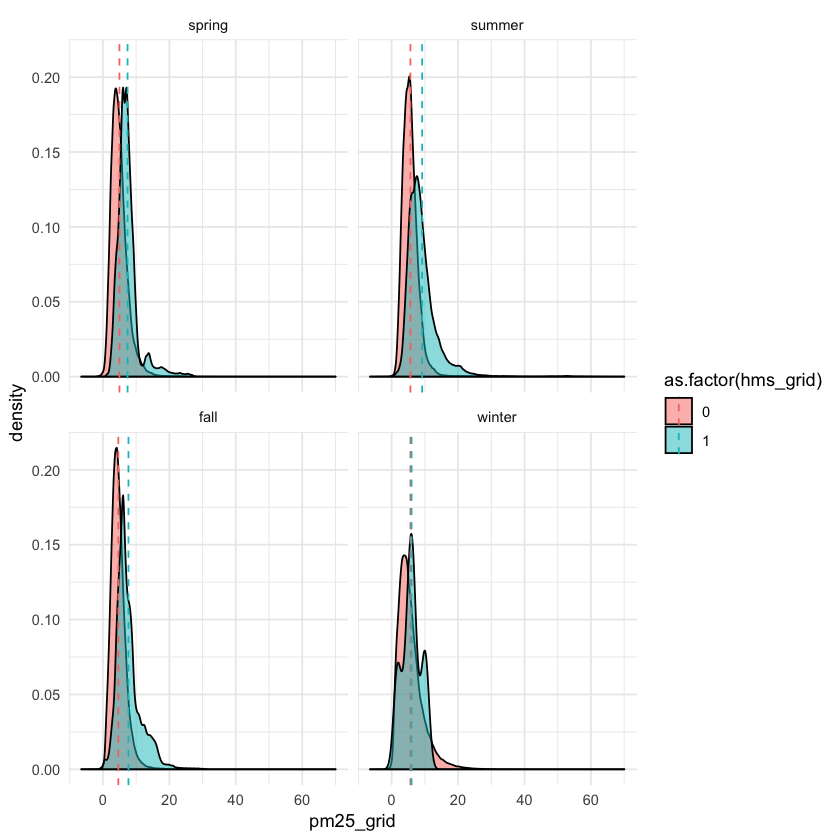

In [28]:
# mean of pm
pm_mean <- grid_pm %>% 
    group_by(season, hms_grid) %>% 
    summarise(pm_mean = mean(pm25_grid))

pm_mean
# distribution plot of PM~2.5~ when HMS is overhead in the grid
pm_dist_plot <- ggplot(grid_pm, aes(x=pm25_grid, group = as.factor(hms_grid), 
                                    fill = as.factor(hms_grid))) +
    geom_density(alpha = 0.5) +
    geom_vline(data=pm_mean, aes(xintercept=pm_mean, color = as.factor(hms_grid)), 
               linetype="dashed") +
    facet_wrap(~season) +
    theme_minimal()
# print plot
print(pm_dist_plot)

When I look at the distribution plot of PM<sub>2.5</sub> when HMS is overhead by season, there is a lot of overlap in the distributions, suggesting that just because smoke is overhead doesn't mean ground-level air quality is impacted by that smoke. The clearest demarcation would be in the summer and fall where levels of PM<sub>2.5</sub> > 15 could be smoke, and levels of 20 are most likely smoke. Dashed lines are mean values for each distribution when HMS is overhead.

### Cardiopulmonary mortality

Loading the list of cardiopulmonary mortality time-stratified case-crossover data frames. I can't remember if I have Colorado-specific ER visits in this file, but they may be part in the meta-wildfire repo. I can retrieve from there.

In [30]:
# load mortality list
load("../../data/health/co_mortality_cc_list.RData")
# load mortality outcome list
load("../../data/health/icd10_outcome.RData")

I'm going to subset each case-crossover data frame to the wildfire season, which is April to October. I'm also going to join to grid-level krigged PM<sub>2.5</sub> values.

In [58]:
# extract a vector of outcome names from the icd10 outcomes list 
outcomes <- names(icd10_outcomes)

# reduce case-crossover list to only summer months and join pm
co_cc_list <- casecross_list %>% 
  # for some variables in the casecross dfs, I need to convert to character, then
  # desired format to make sure it's right
  map(~ mutate(., outcome = as.numeric(as.character(outcome)),
               date = as.Date(as.character(date_of_death)),
               month = as.factor(lubridate::month(date))) %>% 
      # filter out 2016; I don't have pm data yet
      filter(date <= "2015-12-30") %>% 
      filter(month %in% 4:10) %>% 
      select(-month) %>% 
      left_join(grid_pm, by = c("wrfgrid_id", "date"))) %>% 
  # add outcome name to each dataframe
  map2(.x = ., .y = outcomes, ~mutate(.x, out_name = .y))

It looks like the mortality data Kirk provided as some errors in WRFGRID assignment, and I'm not sure I'll be able to join by grid id unless Kirk reassigns grid id. My guess is some values were chopped off. Zip and county fips are fine.